In [1]:
import os
import numpy as np
import tensorflow as tf

In [2]:
import cs230_project_utilities as utils

In [3]:
# Utility functions for creating TFRecord datasets
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def bytes_list_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

# Convert raw data to TFRecords

In [4]:
def tf_example_for_slice_in_sequence(index, path, fft, image, cls):
    
    assert (image.shape[0] == image.shape[1] == fft.shape[0] == fft.shape[1] and
            image.shape[0] == 256 and fft.shape[-1] == 2), 'Image and fft shapes must be 256 x 256'
    
    # Create list of bytes with .tostring() for multidimensional ndarrays.
    example = tf.train.Example(features=tf.train.Features(feature={
        'path': bytes_feature(path.encode('utf-8')),
        'sequence_index': int64_feature(index),
        'fft': bytes_feature(fft.tostring()),
        'image': bytes_feature(image.tostring()),
        'dimension': int64_feature(image.shape[0]), # save dimension of fft and image to restore these keys
        'class': int64_feature(cls)
    }))
    
    return example

In [5]:
def tf_examples_for_h5_file_having_class(path, include_class):
    
    h5_data = utils.automap.read_h5_file(path)
    
    # Raw kspace data
    magnitude_sequence = h5_data['magnitude']
    phase_sequence = h5_data['phase']
    fft_sequence = np.concatenate((np.expand_dims(magnitude_sequence, axis=3),
                                   np.expand_dims(phase_sequence, axis=3)),
                                  axis=3)
    
    # Expected reconstruction images
    image_sequence = h5_data['images']
    image_sequence = np.expand_dims(image_sequence, axis=-1) # model expects 4 dims
    
    # Contains info on positive/negative samples
    class_sequence = h5_data['classification']

    examples = []
    for i in range(len(image_sequence)):
        example = tf_example_for_slice_in_sequence(i, path, fft_sequence[i],
                                                      image_sequence[i], class_sequence[i])
        
        if int(class_sequence[i]) == include_class:
            examples.append(example)
        
    return examples

In [6]:
def convert_dataset_to_tfrecord_files_for_class(h5_paths, dataset_directory, tfrecord_directory, include_class):
    tfrecord_file_pattern = os.path.join(tfrecord_directory, 'class_{}'.format(include_class), 'shard-{}.tfrecord')
    tfrecord_index = 0
    max_examples_per_tfrecord_file = 512
    examples_in_current_tfrecord_file = 0

    os.makedirs(os.path.dirname(tfrecord_file_pattern), exist_ok=True)
    
    tfrecord_path = tfrecord_file_pattern.format(tfrecord_index)
    writer = tf.io.TFRecordWriter(tfrecord_path)
    
    for path in h5_paths:
        try:
            examples = tf_examples_for_h5_file_having_class(path, include_class=include_class)
            for example in examples:
                writer.write(example.SerializeToString())
                examples_in_current_tfrecord_file += 1
                
                if examples_in_current_tfrecord_file >= max_examples_per_tfrecord_file:
                    writer.close()
                    tfrecord_index += 1
                    tfrecord_path = tfrecord_file_pattern.format(tfrecord_index)
                    writer = tf.io.TFRecordWriter(tfrecord_path)
                    examples_in_current_tfrecord_file = 0
                
        except Exception as e:
            print('Error creating example: {}'.format(e))

## Run conversion

In [7]:
raw_dataset_directory = '/dev/data'
tfrecord_directory = '/dev/tfrecords'

In [8]:
# Prepare test, dev, train splits

np.random.seed(0) # for reproducibility
h5_files = utils.automap.find_dataset_files(raw_dataset_directory)
h5_paths = [h5_files[key]['h5'] for key in np.random.permutation(list(h5_files.keys()))]

fraction_test, fraction_dev = 0.1, 0.1
num_paths = len(h5_paths)
num_test = int(num_paths * fraction_test) + 1
num_dev = int(num_paths * fraction_dev) + 1
test_paths = h5_paths[:num_test]
dev_paths = h5_paths[num_test:num_test + num_dev]
train_paths = h5_paths[num_test + num_dev:]

Found 134 .h5 files and 134 .txt files.


In [9]:
convert_dataset_to_tfrecord_files_for_class(test_paths, raw_dataset_directory, '/dev/tfrecords/test', include_class=0)
convert_dataset_to_tfrecord_files_for_class(test_paths, raw_dataset_directory, '/dev/tfrecords/test', include_class=1)

convert_dataset_to_tfrecord_files_for_class(dev_paths, raw_dataset_directory, '/dev/tfrecords/dev', include_class=0)
convert_dataset_to_tfrecord_files_for_class(dev_paths, raw_dataset_directory, '/dev/tfrecords/dev', include_class=1)

convert_dataset_to_tfrecord_files_for_class(train_paths, raw_dataset_directory, '/dev/tfrecords/train', include_class=0)
convert_dataset_to_tfrecord_files_for_class(train_paths, raw_dataset_directory, '/dev/tfrecords/train', include_class=1)

Error creating example: index 1 is out of bounds for axis 0 with size 1
Error creating example: Image and fft shapes must be 256 x 256
Error creating example: index 1 is out of bounds for axis 0 with size 1
Error creating example: Image and fft shapes must be 256 x 256


In [10]:
ll -hR /dev/tfrecords/test /dev/tfrecords/dev /dev/tfrecords/train

/dev/tfrecords/dev:
total 0
drwxrwxr-x 2 ubuntu 60 May 27 09:07 class_0/
drwxrwxr-x 2 ubuntu 60 May 27 09:07 class_1/

/dev/tfrecords/dev/class_0:
total 70M
-rw-rw-r-- 1 ubuntu 70M May 27 21:02 shard-0.tfrecord

/dev/tfrecords/dev/class_1:
total 88M
-rw-rw-r-- 1 ubuntu 88M May 27 21:02 shard-0.tfrecord

/dev/tfrecords/test:
total 0
drwxrwxr-x 2 ubuntu 60 May 27 09:06 class_0/
drwxrwxr-x 2 ubuntu 60 May 27 09:06 class_1/

/dev/tfrecords/test/class_0:
total 92M
-rw-rw-r-- 1 ubuntu 92M May 27 21:02 shard-0.tfrecord

/dev/tfrecords/test/class_1:
total 55M
-rw-rw-r-- 1 ubuntu 55M May 27 21:02 shard-0.tfrecord

/dev/tfrecords/train:
total 0
drwxrwxr-x 2 ubuntu 80 May 27 09:07 class_0/
drwxrwxr-x 2 ubuntu 80 May 27 09:07 class_1/

/dev/tfrecords/train/class_0:
total 622M
-rw-rw-r-- 1 ubuntu 385M May 27 21:02 shard-0.tfrecord
-rw-rw-r-- 1 ubuntu 238M May 27 21:02 shard-1.tfrecord

/dev/tfrecords/train/class_1:
total 478M
-rw-rw-r-- 1 ubuntu 385M May 27 21:02 shard-0.tfrecord
-rw-rw-r-- 1 ubunt

# Read converted dataset

In [159]:
def dataset_input_fn(data_locations, batch_size):
    '''
    Returns iterator of automap data located in `data_locations`.
    
    data_locations:  A string, a list of strings, or a `tf.Tensor` of string type
    (scalar or vector), representing the filename glob (i.e. shell wildcard)
    pattern(s) that will be matched.
    '''
#     data_locations = ['/dev/tfrecords/train/class_1/*.tfrecord']
    filenames = tf.data.TFRecordDataset.list_files(data_locations)
    dataset = tf.data.TFRecordDataset(filenames)

    # Use `tf.parse_single_example()` to extract data from a `tf.Example`
    # protocol buffer, and perform any additional per-example processing.
    def parser(record):
        keys_to_features = {
            "path": tf.FixedLenFeature((), tf.string, ""),
            "sequence_index": tf.FixedLenFeature((), tf.int64, -1),
            "fft": tf.FixedLenFeature((), tf.string, ''),
            "image": tf.FixedLenFeature((), tf.string, ''),
            "dimension": tf.FixedLenFeature((), tf.int64, -1),
            "class": tf.FixedLenFeature((), tf.int64, -1)
        }
        parsed = tf.parse_single_example(record, keys_to_features)
        
        # Perform additional preprocessing on the parsed data.
        parsed['fft'] = tf.decode_raw(parsed['fft'], out_type=tf.float32)
        parsed['image'] = tf.decode_raw(parsed['image'], out_type=tf.float32)
        
        parsed['fft'] = tf.reshape(parsed['fft'], [parsed['dimension'], parsed['dimension'], 2])
        parsed['image'] = tf.reshape(parsed['image'], [parsed['dimension'], parsed['dimension'], 1])

        return parsed['fft'], parsed['image']

    # Use `Dataset.map()` to build a pair of a feature dictionary and a label
    # tensor for each example.
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.batch(batch_size)
#     dataset = dataset.repeat(1) # repeat indefinitely

    # Each element of `dataset` is tuple containing a dictionary of features
    # (in which each value is a batch of values for that feature), and a batch of
    # labels.
    return dataset

In [12]:
# Fetch a sample

In [13]:
data_locations = tf.placeholder(tf.string, shape=[None])

In [14]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [15]:
dataset = dataset_input_fn(data_locations, batch_size=8)
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.

# Initialize `iterator` with training data.
train_data_locations = ['/dev/tfrecords/train/class_1/*.tfrecord']
sess.run(iterator.initializer, {data_locations: train_data_locations})

In [17]:
next_batch

{'class': <tf.Tensor 'IteratorGetNext:0' shape=(?,) dtype=int64>,
 'dimension': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int64>,
 'fft': <tf.Tensor 'IteratorGetNext:2' shape=(?, ?, ?, 2) dtype=float32>,
 'image': <tf.Tensor 'IteratorGetNext:3' shape=(?, ?, ?, 1) dtype=float32>,
 'path': <tf.Tensor 'IteratorGetNext:4' shape=(?,) dtype=string>,
 'sequence_index': <tf.Tensor 'IteratorGetNext:5' shape=(?,) dtype=int64>}

In [18]:
sample = sess.run(next_batch)

In [19]:
sample.keys()

dict_keys(['class', 'dimension', 'fft', 'image', 'path', 'sequence_index'])

## Inspect a few samples in converted dataset

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 12) # increase size of subplots
plt.rcParams['image.cmap'] = 'gray' # b/w images

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


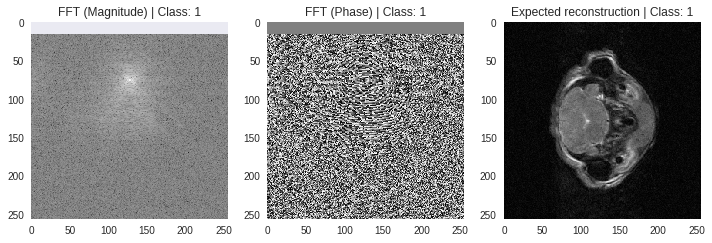

In [21]:
fft_mag = sample['fft'][0, ..., 0]
fft_ang = sample['fft'][0, ..., 1]

cls = int(sample['class'][0])

plt.subplot(1, 3, 1)
plt.title('FFT (Magnitude) | Class: {}'.format(cls))
utils.plot.imshowfft(fft_mag)

plt.subplot(1, 3, 2)
plt.title('FFT (Phase) | Class: {}'.format(cls))
utils.plot.imshowgray(fft_ang)

plt.subplot(1, 3, 3)
plt.title('Expected reconstruction | Class: {}'.format(cls))
image = sample['image'][0, ..., 0]
utils.plot.imshowgray(image)

# Model

In [35]:
def automap_model_tfk(XXX, Y):
    N = 256
    small_N = N // 4 # after downsampling by 2 twice
    X = tf.keras.layers.Input(shape=(N, N, 2))
    conv_downsample1 = tf.keras.layers.Conv2D(16, (4, 4), strides=(2, 2), activation='tanh', padding='same')(X)
    conv_downsample2 = tf.keras.layers.Conv2D(4, (4, 4), strides=(1, 1), activation='tanh', padding='same')(conv_downsample1)
    conv_downsample3 = tf.keras.layers.Conv2D(2, (4, 4), strides=(2, 2), activation='tanh', padding='same')(conv_downsample2)
    X1 = tf.keras.layers.Flatten()(conv_downsample3)
    
    # Workaround for: ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.
    X1 = tf.keras.layers.Reshape(target_shape=((small_N ** 2) * 2,))(X1)
    
    fc1 = tf.keras.layers.Dense((small_N ** 2) * 2, activation = 'tanh')(X1)
    fc2 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc1)
    fc3 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc2)
    X2 = tf.keras.layers.Reshape((small_N, small_N, 1))(fc3)
    conv1_1 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(X2)
    conv1_2 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(conv1_1)
    conv1_3a = tf.keras.layers.Conv2DTranspose(small_N, 9, activation='relu', padding='same')(conv1_2)
    conv1_3b = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3a)
    conv1_3c = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3b)
    
    Y_pred = tf.keras.layers.Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3c)
    
    loss = tf.reduce_mean(tf.squared_difference(Y, Y_pred))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    
    return Y_pred, loss, optimizer

In [36]:
# For testing:
# X = tf.placeholder(tf.float32, [None, 256, 256, 2])
# Y = tf.placeholder(tf.float32, [None, 256, 256, 1])

X = next_batch['fft']
Y = next_batch['image']
CLS = next_batch['class']

In [37]:
Y_pred, loss, optimizer = automap_model_tfk(X, Y)

In [25]:
init = tf.global_variables_initializer()
sess.run(init)

In [26]:
train_epochs = 1

with sess.as_default():
    
    # Train for a few epochs
    for epoch in range(train_epochs):
        
        train_data_locations = ['/dev/tfrecords/dev/class_1/*.tfrecord']
        sess.run(iterator.initializer, {data_locations: train_data_locations})
        
        print('>>> Beginning epoch {}'.format(epoch))

        while True:
            try:
                _, current_loss, y = sess.run([optimizer, loss, Y_pred])
            except tf.errors.OutOfRangeError:
                print('<<< Finished epoch {}'.format(epoch))
                break
    
    # Evaluate loss on development set
    dev_data_locations = ['/dev/tfrecords/dev/class_1/*.tfrecord']
    sess.run(iterator.initializer, {data_locations: dev_data_locations})
    
    while True:
        try:
            current_loss, y_pred, y, x, cls = sess.run([loss, Y_pred, Y, X, CLS])
        except tf.errors.OutOfRangeError:
            break


>>> Beginning epoch 0
<<< Finished epoch 0


Class: 1


/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


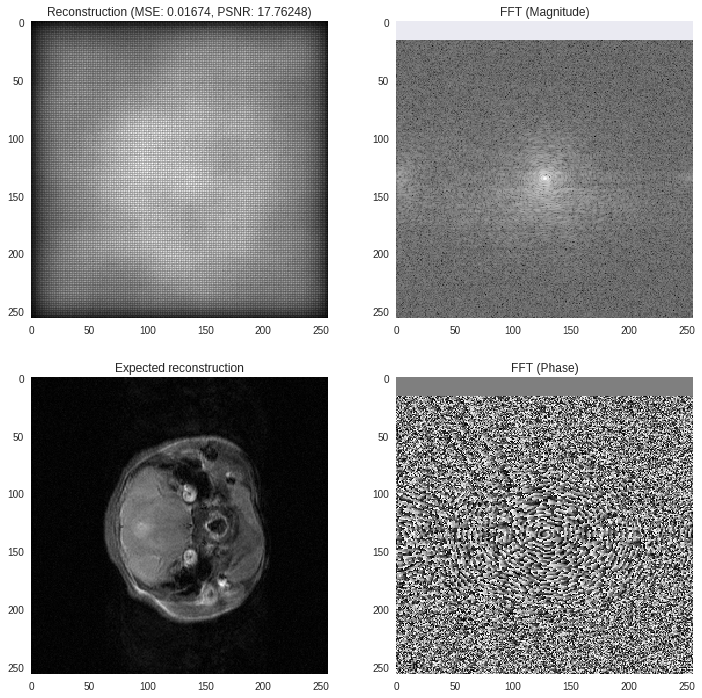

Class: 1


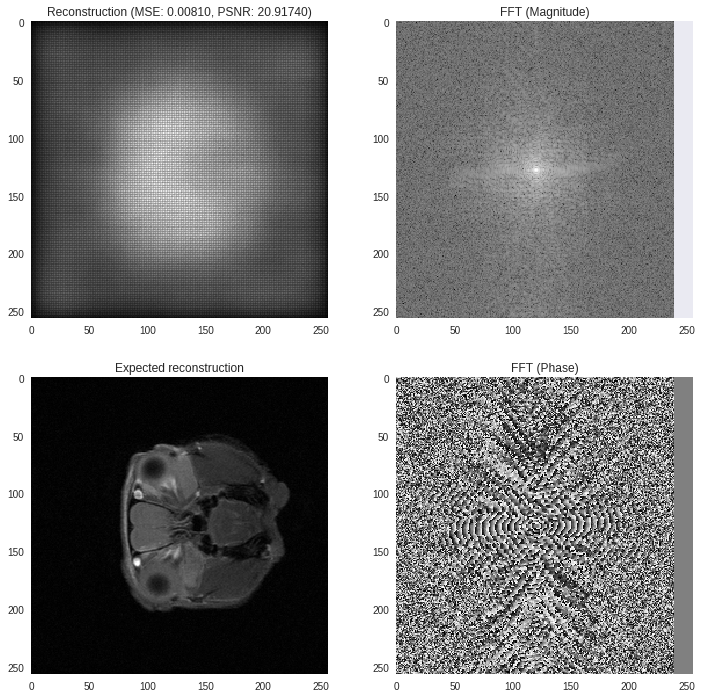

Class: 1


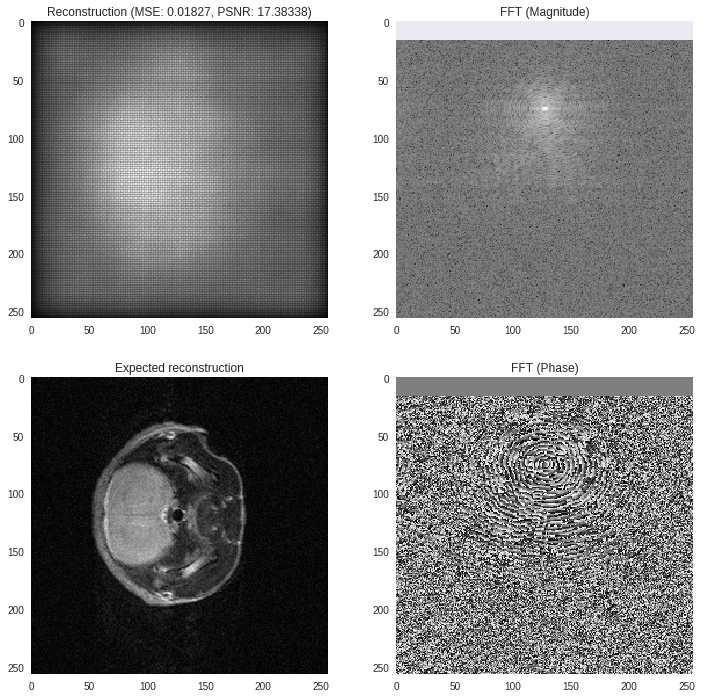

Class: 1


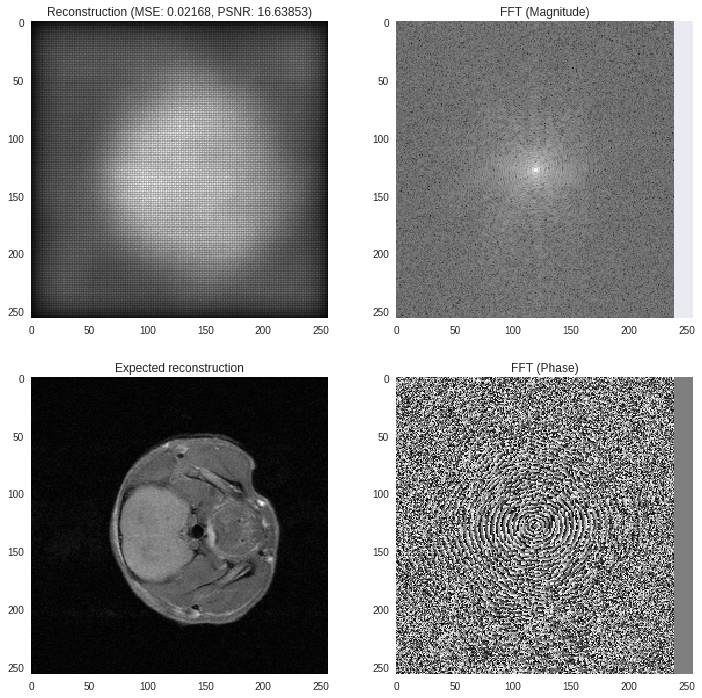

In [27]:
for i in range(len(x)):
    
    fft_mag = x[i, ..., 0]
    fft_ang = x[i, ..., 1]
    c = int(cls[i])
    reconstruction = y_pred[i, ..., 0]
    reconstruction[reconstruction < 0] = 0
    reconstruction[reconstruction > 1] = 1
    image = y[i, ..., 0]

    print('Class: {}'.format(c))
    
    MSE = utils.signal_processing.mean_square_error(reconstruction, image)
    PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=1.0)

    plt.subplot(2, 2, 1)
    plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
    utils.plot.imshowgray(reconstruction)

    plt.subplot(2, 2, 2)
    plt.title('FFT (Magnitude)')
    utils.plot.imshowfft(fft_mag)

    plt.subplot(2, 2, 3)
    plt.title('Expected reconstruction')
    utils.plot.imshowgray(image)

    plt.subplot(2, 2, 4)
    plt.title('FFT (Phase)')
    utils.plot.imshowgray(fft_ang)

    plt.show()

# Keras training

In [169]:
def kautomap_model(XXX, Y):
    N = 256
    small_N = N // 4 # after downsampling by 2 twice
    X = tf.keras.layers.Input(shape=(N, N, 2))
    conv_downsample1 = tf.keras.layers.Conv2D(16, (4, 4), strides=(2, 2), activation='tanh', padding='same')(X)
    conv_downsample2 = tf.keras.layers.Conv2D(4, (4, 4), strides=(1, 1), activation='tanh', padding='same')(conv_downsample1)
    conv_downsample3 = tf.keras.layers.Conv2D(2, (4, 4), strides=(2, 2), activation='tanh', padding='same')(conv_downsample2)
    X1 = tf.keras.layers.Flatten()(conv_downsample3)
    
    # Workaround for: ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.
    X1 = tf.keras.layers.Reshape(target_shape=((small_N ** 2) * 2,))(X1)
    
    fc1 = tf.keras.layers.Dense((small_N ** 2) * 2, activation = 'tanh')(X1)
    fc2 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc1)
    fc3 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc2)
    X2 = tf.keras.layers.Reshape((small_N, small_N, 1))(fc3)
    conv1_1 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(X2)
    conv1_2 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(conv1_1)
    conv1_3a = tf.keras.layers.Conv2DTranspose(small_N, 9, activation='relu', padding='same')(conv1_2)
    conv1_3b = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3a)
    conv1_3c = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3b)
    
    Y_pred = tf.keras.layers.Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3c)
    
    model = tf.keras.Model(inputs=X, outputs=Y_pred)
    
    return model

In [183]:
data_locations = tf.placeholder(tf.string, shape=[None])
dataset = dataset_input_fn(data_locations, batch_size=8)
# iterator = dataset.make_one_shot_iterator()
# next_batch = iterator.get_next()

In [171]:
X = next_batch['fft']
Y = next_batch['image']
CLS = next_batch['class']

TypeError: tuple indices must be integers or slices, not str

In [184]:
model = kautomap_model(None, None)


In [185]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(lr=1e-4)
)

In [186]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      528       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 4)       1028      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 2)         130       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              67117056  
__________

In [187]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [153]:
dev_data_locations = ['/dev/tfrecords/dev/class_1/*.tfrecord']
sess.run(iterator.initializer, {data_locations: dev_data_locations})

In [188]:
with sess.as_default():
    training_history = model.fit(
        dataset,
        verbose=1, # set to 0 to suppress chatty output; use Tensorboard instead
        epochs=1)

ValueError: When using iterators as input to a model, you should specify the `steps_per_epoch` argument.

In [178]:
next_batch[1].set_shape([8, 256, 256, 1])

In [179]:
next_batch[0].set_shape([8, 256, 256, 2])

In [157]:
next_batch

(<tf.Tensor 'IteratorGetNext:0' shape=(8, 256, 256, 2) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=(8, 256, 256, 1) dtype=float32>)

In [139]:
next_batch['image']

<tf.Tensor 'IteratorGetNext:3' shape=(8, 256, 256, 1) dtype=float32>

In [167]:
next_batch

(<tf.Tensor 'IteratorGetNext:0' shape=(8, 256, 256, 2) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=(8, 256, 256, 1) dtype=float32>)

In [177]:
next_batch

(<tf.Tensor 'IteratorGetNext:0' shape=(?, ?, ?, 2) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=(?, ?, ?, 1) dtype=float32>)

In [182]:
tf.reset_default_graph()

In [189]:
dataset

<DatasetV1Adapter shapes: ((?, ?, ?, 2), (?, ?, ?, 1)), types: (tf.float32, tf.float32)>